
# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

Le projet a été développé à l'aide de Marilou Farmer, étudiant en génie informatique, et de Gabriel Gobeil, étudiant à la maîtrise en mathématiques appliqués.


# Projet : Classification des tumeurs

La description du projet est disponible à l'adresse suivante :
https://www.kaggle.com/t/b311b4a3cd194ea48165c33c8707cdfa

Ce calepin Jupyter de base permet de 

1. Charger les données fournies.
2. Effectuer une analyse exploratoire sommaire des données.
3. Développer un modèle simple de prédiction.
4. Générer le fichier de prédictions à téléverser sur Kaggle.

Dans un premier temps, vous devrez récupérer les données sous l'onglet *data* du site Kaggle. Il y a deux fichiers :
- train.csv
- test.csv

Le fichier *train.csv* contient les données sur lesquelles vous pouvez entraîner votre modèle. Il sera ensuite évaluée sur les données de l'ensemble *test.csv* lorsque vous aurez téléversé vos prédictions sur Kaggle. 

**Attention**. Vous êtes limités à deux soumissions par jour par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs candidats.

### Quelques conseils

Votre calepin doit permettre de suivre clairement votre raisonnement et de reproduire vos résultats. Garder à l'esprit que vos résultats et votre démarche doivent être reproductibles par une personne à l'extérieur de votre équipe. Le calepin constitue le rapport. Servez vous des cellules de texte pour décrire ce que vous faites.

Je vous encourage fortement à faire une analyse exploratoire de vous données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée par les débutants mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se retrouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin de base contient un modèle très simple de prédiction : la régression logistique simple. Ce sera votre travail d'améliorer ces prédictions de base en complexifiant le modèle de régression ou en changeant de méthode.

Prenez la peine de tout documenter, même les essais infructueux. Ce n'est pas la peine de les expliquer en détails, mais c'est important de les mentionner au moins succintement dans la discussion avec une raison possible pour leur échec. 

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode à moins bien performée que ce à quoi vous vous attendiez. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données, etc. L'idée est de guider le prochain scientifique qui prendra la relève de votre travail.

In [80]:
using CSV
using DataFrames
using Distributions
using Gadfly
using GLM
using LinearAlgebra
using Statistics

In [81]:
include("functions.jl")

compute_VIF (generic function with 1 method)

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [82]:
data = CSV.read("train.csv")
first(data,5)

,id,radius,texture,perimeter,area,smoothness,compactness,concavity
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,16.641,21.3452,110.798,901.347,0.112388,0.145148,0.153247
2,2,13.6884,21.1035,90.5878,578.09,0.0941204,0.101193,0.035445
3,3,12.9131,14.3055,85.3309,511.539,0.0863069,0.136213,0.13536
4,4,12.9474,15.1198,86.2821,539.445,0.0925851,0.0849802,0.0937507
5,5,19.4972,24.8959,127.491,1200.37,0.101691,0.0989018,0.166237


### Primary Component Analysis

In [83]:
X = convert(Array{Float64}, data[:, 2:end-1])

y = convert(Array{Float64}, data.diagnosis)

Z = standardize(X)
standardize!(y)

print("")

In [95]:
# Décomposition en valeurs singulières de la matrice rectangulaire Z
F = svd(Z)

# Extraction de la matrice U
U = F.U

# Extraction de la matrice V
V = F.V

# Extraction des valeurs singulières
γ = F.S

print("")

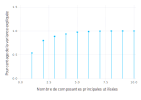

In [96]:
# Représentation du pourcentage de la variance expliquée
v = cumsum(γ.^2) / sum(γ.^2)

plot(x=1:10, y=v, Geom.point, Geom.hair,
    Guide.xlabel("Nombre de composantes principales utilisées"), 
    Guide.ylabel("Pourcentage de la variance expliquée"))

In [97]:
# Calcul de la matrice des composantes principales
T = Z*V

455×10 Array{Float64,2}:
 -2.30348    0.263897   -0.0253616  -0.206301    …   0.00368751  -0.0248962
  0.815035  -0.0873692  -0.51179     0.670163       -0.131697    -0.065621
  0.495655   0.253765    0.819489    0.920805        0.0201727   -0.00589955
  0.829191   0.129365    0.79068    -0.0712925      -0.0657387   -0.075455
 -2.51993   -2.3219     -0.425658    0.124605       -0.00693279   0.0111712
 -0.430611  -2.43374    -0.583389    0.220233    …  -0.0972972    0.0832338
 -7.12092   -0.6805     -0.612982   -0.148038        0.11483     -0.0304405
 -2.0252     1.27188    -0.652185    2.07324        -0.126602    -0.00863538
 -1.46009    0.880826    0.667644   -0.0941011      -0.119575     0.0617737
  2.65116   -0.986307    0.13002    -0.271348        0.0444123    0.0182951
  2.8508     0.247595    0.527632   -0.30809     …   0.173773     0.0615871
 -3.08141    0.162766   -0.719466    1.55163        -0.136286     0.0100809
  1.18357    1.07389     1.22489    -0.27892         0.0293632 

## 2. Analyse exploratoire sommaire

C'est une analyse exploratoire sommaire. Je vous encourage formtement à poursuivre cette analyse.

#### 2.1 Diagnostic vs radius

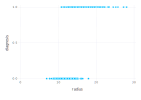

In [87]:
plot(data, x = :radius, y = :diagnosis)

#### 2.2 Diagnostic vs (radius, concave_point)

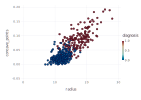

In [88]:
plot(data, x = :radius, y = :concave_points, color = :diagnosis)

## 3. Modèle de régression logistique

Modèle de régression logistique très simple n'utilisant que le radius comme variable explicative. À vous d'améliorer ce modèle ou en proposer un autre.

Estimation des paramètres sur l'ensemble d'entraînement.

In [89]:
M = glm(@formula(diagnosis ~ radius), data,  Bernoulli(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Bernoulli{Float64},LogitLink},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

diagnosis ~ 1 + radius

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error       z  Pr(>|z|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  -15.0674     1.44169   -10.45    <1e-24  -17.8931    -12.2417
radius         1.02448    0.101731   10.07    <1e-23    0.825093    1.22387
───────────────────────────────────────────────────────────────────────────

## 4. Prédiction de la survie des passagers de l'ensemble de test

On utilise le modèle ajusté pour effectuer les prédictions sur l'ensemble de test.


#### 4.1 Chargement des données de l'ensemble de test

In [90]:
test = CSV.read("test.csv");

#### 4.2 Estimation de la probabilité de survie de chacun des passagers de l'ensemble de test

In [91]:
θ̂ = predict(M, test)

114-element Array{Union{Missing, Float64},1}:
 0.14571468142962815
 0.1511743697155315
 0.550828819713673
 0.9988295016769887
 0.39801516356464134
 0.2890849265445491
 0.20498585943345238
 0.9976745794142036
 0.33059451602261425
 0.9871754802616004
 0.004743540098817934
 0.06316593765550603
 0.048547889223318
 ⋮
 0.012410670294433648
 0.6592604151369466
 0.006325776967339729
 0.036371630575228374
 0.6541107965948428
 0.9934644402518125
 0.9893661916305468
 0.42688744023027764
 0.079211302493909
 0.0007603875102279222
 0.9999977779437453
 0.08443786318217555

#### 4.3 Définition de la régle de décision pour le diagnostic

In [92]:
Ŷ = zeros(Int64, size(test,1))
Ŷ[θ̂.>.5] .= 1;

#### 4.4 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (id) et une colonne des diagnostics prédits.

In [93]:
prediction = DataFrame(id = test.id, diagnosis = Ŷ)
CSV.write("benchmark_predictions.csv",prediction)

"benchmark_predictions.csv"

In [94]:
number(true)

LoadError: UndefVarError: number not defined